In [1]:
# In this notebook, I analyze batted ball data from Major League Baseball (MLB)

# First, I calculate the "estimated batting average" (i.e. the hit probability) of balls put in play 
# based upon two parameters: the speed at which the ball was hit, 
# and the angle with respect to the vertical at which the ball was hit.
# (I am obviously not the first person to do this; this is a first pass at analysis of scraped data.
# For an introduction to the topic see https://fivethirtyeight.com/features/the-new-science-of-hitting/)

# Second, I show that batted balls that result in a fielder error
# (e.g. the fieler dropping the ball) have a higher expected batting average than plays that result in an out

# Batters do not receive credit for fielder errors; 
# in fact, their batting average is penalized as though they had hit into an out
# I will show that, by my metric of estimated batting average, batters deserve at least some credit
# when fielders make mistakes (e.g. maybe the batter hit the ball slightly harder at certain launch angles)

In [2]:
import numpy as np
import scipy as sc
from bs4 import BeautifulSoup
import pybaseball as pyb
import pandas as pd
import requests
import re
import matplotlib.pyplot as plt
from scipy import stats
import sklearn as sk
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler 
def center(L):
    return [np.mean([a, b]) for (a, b) in list(zip(L[:-1], L[1:]))]

In [5]:
# use pybaseball to pull data from every single pitch in Major League Baseball
# Between 2016 and 2018
data16 = pyb.statcast(start_dt='2016-04-03', end_dt='2016-10-02')
data17 = pyb.statcast(start_dt='2017-04-02', end_dt='2017-10-03')
data18 = pyb.statcast(start_dt='2018-03-29', end_dt='2018-10-01')

This is a large query, it may take a moment to complete
Completed sub-query from 2016-04-03 to 2016-04-08
Completed sub-query from 2016-04-09 to 2016-04-14
Completed sub-query from 2016-04-15 to 2016-04-20
Completed sub-query from 2016-04-21 to 2016-04-26
Completed sub-query from 2016-04-27 to 2016-05-02
Completed sub-query from 2016-05-03 to 2016-05-08
Completed sub-query from 2016-05-09 to 2016-05-14
Completed sub-query from 2016-05-15 to 2016-05-20
Completed sub-query from 2016-05-21 to 2016-05-26
Completed sub-query from 2016-05-27 to 2016-06-01
Completed sub-query from 2016-06-02 to 2016-06-07
Completed sub-query from 2016-06-08 to 2016-06-13
Completed sub-query from 2016-06-14 to 2016-06-19
Completed sub-query from 2016-06-20 to 2016-06-25
Completed sub-query from 2016-06-26 to 2016-07-01
Completed sub-query from 2016-07-02 to 2016-07-07
Completed sub-query from 2016-07-08 to 2016-07-13
Completed sub-query from 2016-07-14 to 2016-07-19
Completed sub-query from 2016-07-20 to 2016-

In [20]:
# Vertical join data (for some reason the grouped query was erroring)

data16_18 = pd.concat([data16, data17, data18], axis= 0)
print([np.shape(i) for i in [data16, data17, data18, data16_18]])

[(715823, 90), (715211, 90), (721190, 90), (2152224, 90)]


In [21]:
print(np.shape(data16_18))
print(sorted(list(np.unique(data16_18.columns))))

(2152224, 90)
['at_bat_number', 'away_score', 'away_team', 'ax', 'ay', 'az', 'babip_value', 'balls', 'bat_score', 'batter', 'bb_type', 'break_angle_deprecated', 'break_length_deprecated', 'des', 'description', 'effective_speed', 'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle', 'events', 'fielder_2', 'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 'fld_score', 'game_date', 'game_pk', 'game_type', 'game_year', 'hc_x', 'hc_y', 'hit_distance_sc', 'hit_location', 'home_score', 'home_team', 'if_fielding_alignment', 'index', 'inning', 'inning_topbot', 'iso_value', 'launch_angle', 'launch_speed', 'launch_speed_angle', 'of_fielding_alignment', 'on_1b', 'on_2b', 'on_3b', 'outs_when_up', 'p_throws', 'pfx_x', 'pfx_z', 'pitch_name', 'pitch_number', 'pitch_type', 'pitcher', 'pitcher.1', 'plate_x', 'plate_z', 'player_name', 'post_away_score', 'post_bat_score', 'post_fld_score', 'post_home_score', 'release_extension', 'releas

In [24]:
# I want to analyze launch_speed and launch_angle
# and compare the feature I build to the MLB's own `estimated_ba_using_speedangle` feature
# Only use pitches that result in a ball in play (i.e. `event` is not NaN)
cols = ['launch_speed', 'launch_angle', 'events', 'estimated_ba_using_speedangle', 'hit_distance_sc']
speed_angles_16_18 = data16_18[cols].dropna()
print(sorted(list(np.unique(speed_angles_16_18['events']))))
print(np.shape(speed_angles_16_18))

['double', 'double_play', 'field_error', 'field_out', 'fielders_choice', 'fielders_choice_out', 'force_out', 'grounded_into_double_play', 'home_run', 'sac_bunt', 'sac_fly', 'sac_fly_double_play', 'single', 'triple', 'triple_play']
(340655, 5)


In [25]:
# These are the only events when a ball is put into play
# Such that batting average either increases or decreases 
# i.e. all "At-Bat"s that do not end in a strikeout
events_in_play = ['single', 'double', 'triple', 'home_run', 
                  'double_play', 'field_error', 'field_out', 'fielders_choice', 'fielders_choice_out',
                 'force_out', 'grounded_into_double_play', 'triple_play']


speed_angles_inplay_16_18 = speed_angles_16_18.loc[speed_angles_16_18['events'].isin(events_in_play)]
print(sorted(list(np.unique(speed_angles_inplay_16_18['events']))))

['double', 'double_play', 'field_error', 'field_out', 'fielders_choice', 'fielders_choice_out', 'force_out', 'grounded_into_double_play', 'home_run', 'single', 'triple', 'triple_play']


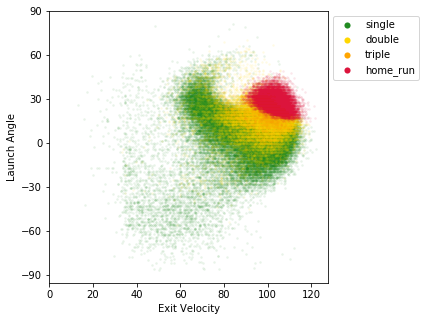

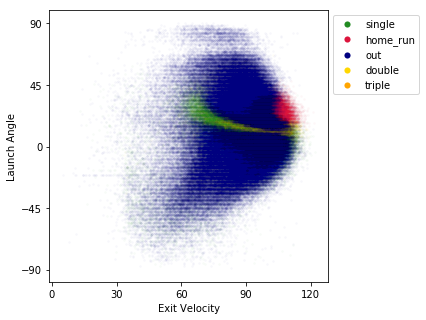

In [26]:
# scatter all balls in play by launch_angle, launch_speed
# Clearly there is some structure here.
# Launch speed and launch angle have some bearing on what kind of hit a batter will get
# Or indeed whether they will get a hit at all

plt.close()
plt.figure(1, (5, 5))
for this_event in events_in_play:
    if this_event == 'single':
        c = 'forestgreen'
    elif this_event == 'double':
        c = 'gold'
    elif this_event == 'triple':
        c = 'orange'
    elif this_event == 'home_run':
        c = 'crimson'
    else:
        continue
    
    l = this_event
    
    df = speed_angles_inplay_16_18.loc[speed_angles_inplay_16_18['events'] == this_event]
    
    plt.scatter(df['launch_speed'], df['launch_angle'], 
                label = l, c=c, s=6, alpha=0.1, lw=0)
plt.yticks(np.linspace(-90, 90, 7))
plt.xticks(np.linspace(0, 120, 7))
plt.xlabel('Exit Velocity')
plt.ylabel('Launch Angle')
leg = plt.legend(markerscale=2.5, loc='upper left', bbox_to_anchor=(1, 1))

for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.show()

plt.figure(1, (5, 5))
for this_event in events_in_play:
    if this_event == 'single':
        c = 'forestgreen'
    elif this_event == 'double':
        c = 'gold'
    elif this_event == 'triple':
        c = 'orange'
    elif this_event == 'home_run':
        c = 'crimson'
    else:
        c = 'navy'
    
    if not(this_event in ['single', 'double', 'triple', 'home_run']):
        l = 'out'
    else:
        l = this_event
    
    df = speed_angles_inplay_16_18.loc[speed_angles_inplay_16_18['events'] == this_event]
    
    plt.scatter(df['launch_speed'], df['launch_angle'], 
                label = l, c=c, s=6, alpha=0.03, lw=0)
plt.yticks(np.linspace(-90, 90, 5))
plt.xticks(np.linspace(0, 120, 5))
plt.xlabel('Exit Velocity')
plt.ylabel('Launch Angle')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
leg = plt.legend(by_label.values(), by_label.keys(),
                 markerscale = 2.5, loc='upper left', bbox_to_anchor=(1, 1))
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.show()

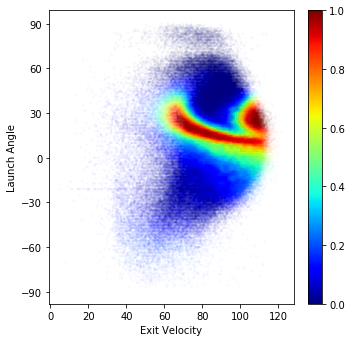

In [28]:
# Apparently statcast estiamtes batting average using these two values
# scatter all the in-play events, color coding by this value
plt.close()
plt.figure(1, (5, 5*1.08))
plt.scatter(speed_angles_inplay_16_18['launch_speed'],
           speed_angles_inplay_16_18['launch_angle'],
           c=speed_angles_inplay_16_18['estimated_ba_using_speedangle'],
           cmap = plt.cm.get_cmap('jet'), s=6, alpha=0.03, lw=0)
plt.yticks(np.linspace(-90, 90, 7))
plt.xticks(np.linspace(0, 120, 7))
plt.xlabel('Exit Velocity')
plt.ylabel('Launch Angle')
cb = plt.colorbar(fraction = 1 - (1 / 1.08))
cb.set_alpha(1)
cb.draw_all()
plt.show()

In [36]:
# After a cursory search, I could find no documentation from the MLB on how they construct their 
# `estimated_ba_using_speedangle` feature (it may come from a model, it may also just be empirical).
# For fun, can I build a model that approximates the actual hit probability 
# using only launch speed and launch angle?

# First, create a binary feature as to whether or not an event is a hit
hitcatlist = ['single', 'double', 'triple', 'home_run']
speed_angles_inplay_16_18['hit'] = speed_angles_inplay_16_18['events'].isin(hitcatlist)
print(sorted(list(np.unique(speed_angles_inplay_16_18['events']))))

# Separate columns into inputs and classes
X = speed_angles_inplay_16_18[['launch_speed', 'launch_angle', 'estimated_ba_using_speedangle']]
Y = speed_angles_inplay_16_18['hit']

# Split into training and testing data
# Save the average and standard devitation to plot in normal units on the backend
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, Y,
                                                                       test_size = 0.1, shuffle=False)

# Only use 'launch_speed' and 'launch_angle'...not 'estimated_ba_using_speedangle'...that would be cheating...
mu_train = np.mean(X_train[['launch_speed', 'launch_angle']], axis=0)
std_train = np.std(X_train[['launch_speed', 'launch_angle']], axis=0)

# Not sure I need these...
mu_test = np.mean(X_test[['launch_speed', 'launch_angle']], axis=0)
std_test = np.std(X_test[['launch_speed', 'launch_angle']], axis=0)

/Users/bennettferris/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


['double', 'double_play', 'field_error', 'field_out', 'fielders_choice', 'fielders_choice_out', 'force_out', 'grounded_into_double_play', 'home_run', 'single', 'triple', 'triple_play']


In [38]:
# use sklearn to build a vanilla 2-layer dense artificial neural network
# Relu activation, 'adam' gradient descent algorithm
MLP = MLPClassifier(activation='relu', alpha=1e-04, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False,
              epsilon=1e-08, hidden_layer_sizes=(8, 8),
              learning_rate='constant', learning_rate_init=0.001,
              max_iter=5000, momentum=0.9, n_iter_no_change=10,
              nesterovs_momentum=True, power_t=0.5, random_state=1,
              shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)


# a scaler to normalize inputs
scaler = StandardScaler()  
# fit only on training data
scaler.fit(X_train[['launch_speed', 'launch_angle']])  
X_train_norm = scaler.transform(X_train[['launch_speed', 'launch_angle']])  
# apply same transformation to test data
X_test_norm = scaler.transform(X_test[['launch_speed', 'launch_angle']])

MLP.fit(X_train_norm, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(8, 8), learning_rate='constant',
       learning_rate_init=0.001, max_iter=5000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

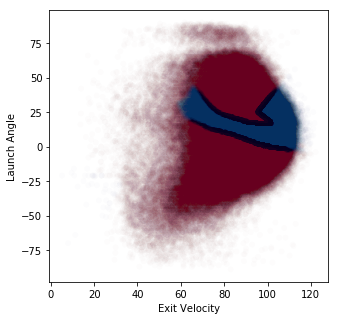

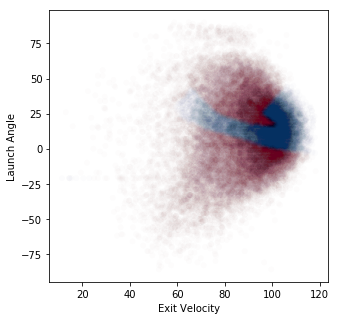

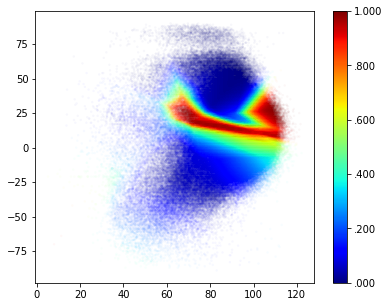

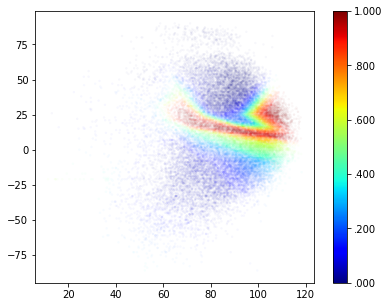

In [39]:
# Make predictions
y_train_pred = MLP.predict(X_train_norm)
y_train_prob = MLP.predict_proba(X_train_norm)
y_test_pred = MLP.predict(X_test_norm)
y_test_prob = MLP.predict_proba(X_test_norm)

# Plot predictions for training data 
# Hits in blue if my estimate of batting average >= 0.5,
# Outs predicted in red otherwise
plt.figure(1, (5, 5))
plt.scatter(X_train['launch_speed'], X_train['launch_angle'], 
            c=y_train_pred, cmap = 'RdBu', lw=0, alpha=0.01)
plt.xlabel('Exit Velocity')
plt.ylabel('Launch Angle')
plt.show()

# Plot the same for test data
plt.figure(2, (5, 5))
plt.scatter(X_test['launch_speed'], X_test['launch_angle'], 
            c=y_test_pred, cmap = 'RdBu', lw=0, alpha=0.01)
plt.xlabel('Exit Velocity')
plt.ylabel('Launch Angle')
plt.show()

# Plot the actual predicted hit probability, training data
plt.close()
frac = .2
pad = .05
plt.figure(3, (5. / (1-frac-pad), 5))
plt.scatter(X_train['launch_speed'], X_train['launch_angle'],
            c=y_train_prob[:, 1], cmap = 'jet', s=6, alpha=0.03, lw=0)
plt.clim(0, 1)
cb = plt.colorbar(fraction = frac, pad=pad)
cb.set_alpha(1)
cb.draw_all()
cb.set_ticks([0, .2, .4, .6, .8, 1.])
cb.set_ticklabels(['.000', '.200', '.400', '.600', '.800', '1.000'])
plt.show()

# Plot the actual predicted hit probability, test data
plt.close()
frac = .2
pad = .05
plt.figure(2, (5. / (1-frac-pad), 5))
plt.scatter(X_test['launch_speed'], X_test['launch_angle'],
            c=y_test_prob[:, 1], cmap = 'jet', s=6, alpha=0.03, lw=0)
plt.clim(0, 1)
cb = plt.colorbar(fraction = frac, pad=pad)
cb.set_alpha(1)
cb.draw_all()
cb.set_ticks([0, .2, .4, .6, .8, 1.])
cb.set_ticklabels(['.000', '.200', '.400', '.600', '.800', '1.000'])
plt.show()

In [40]:
# Compare my model of hit probability and binary outcomes (y_train_prob y_train_pred)
# to MLB's estimate batting average and hit probability for these batted balls

eba_train = X_train['estimated_ba_using_speedangle']
eba_train_pred = eba_train >= 0.5
eba_test = X_test['estimated_ba_using_speedangle']
eba_test_pred = eba_test >= 0.5

print('How accurately the model predicts hit probability, Train and Test:')
print(MLP.score(X_train_norm, y_train), MLP.score(X_test_norm, y_test))

from sklearn.metrics import accuracy_score
print('\n', 
      "How accurately Statcast's 'estimated_ba_using_speedangle' feature predicts hit probability, Train and Test:")
print(accuracy_score(eba_train_pred, y_train), accuracy_score(eba_test_pred, y_test)) 

print('\n',
      "How accurately the model predicts the 'estimated_ba_using_speedangle' feature, Train and Test:")
print(MLP.score(X_train_norm, eba_train_pred), MLP.score(X_test_norm, eba_test_pred))


How accurately the model predicts hit probability, Train and Test:
0.7913464585644113 0.7913485249116136

 How accurately Statcast's 'estimated_ba_using_speedangle' feature predicts hit probability, Train and Test:
0.7937001531717107 0.7970230844647791

 How accurately the model predicts the 'estimated_ba_using_speedangle' feature, Train and Test:
0.968173955527386 0.9637838319617339



 Correlation between Bennett's predicted hit probability vs. Statcast's, training data
(0.9905089991983662, 0.0)


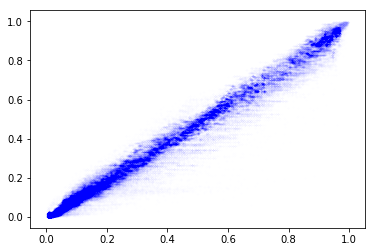


 Correlation between Bennett's predicted hit probability vs. Statcast's, testing data
(0.9880647070869388, 0.0)


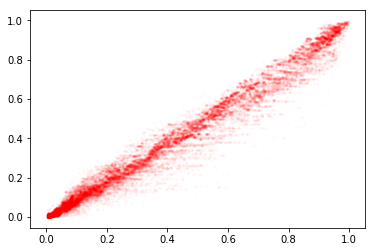

In [41]:
# Okay, that's pretty weird. 
# Seems like my model does a much better job predicting Statcast's feature ('estimated_ba_using_speedangle)
# (Upon which it was NOT TRAINED) than it does predicting actual hit probability...
# Let's plot my predicted probabilities against those of Statcast

print('\n', "Correlation between Bennett's predicted hit probability vs. Statcast's, training data")
print(sc.stats.pearsonr(y_train_prob[:, 1], eba_train))
plt.scatter(y_train_prob[:, 1], eba_train, c='b', lw=0, s=6, alpha=0.005)
plt.show()

print('\n', "Correlation between Bennett's predicted hit probability vs. Statcast's, testing data")
print(sc.stats.pearsonr(y_test_prob[:, 1], eba_test))
plt.scatter(y_test_prob[:, 1], eba_test, c='r', lw=0, s=6, alpha=0.03)
plt.show()

# Suffice it to say that, while my model is only 80% accurate,
# it is very close to the MLB's own model of batting average based on these features

Errors: 4042 Outs: 213128 Hits: 119417
Percentage of balls put in play that are errors: 1.2008782276201992 %
P-value on assumption that Error Estimated BA is drawn from same distribution as those of outs: 2.884221983196906e-91


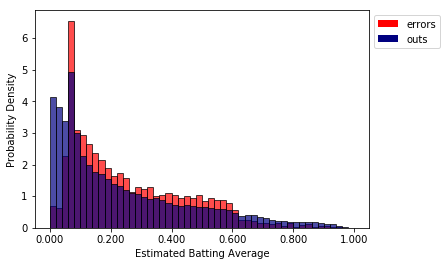

In [45]:
# Now that I'm satisfied with the my model of hit probability, 
# I want to look at how the hit probability on outs differs from that of errors
# Remember, Batters get 0 credit for plays during which fielders make errors

hitcatlist = ['single', 'double', 'triple', 'home_run']
outcatlist = [e for e in events_in_play if (not e in hitcatlist) and (not e == 'field_error')]
errors = speed_angles_inplay_16_18.loc[speed_angles_inplay_16_18['events'] == 'field_error']
outs = speed_angles_16_18.loc[speed_angles_16_18['events'].isin(outcatlist)]
hits = speed_angles_16_18.loc[speed_angles_16_18['events'].isin(hitcatlist)]

# Calculate my estimated batting average for all errors, outs, and hits
error_eba = MLP.predict_proba(scaler.transform(errors[['launch_speed', 'launch_angle']]))[:, 1]
out_eba = MLP.predict_proba(scaler.transform(outs[['launch_speed', 'launch_angle']]))[:, 1]
hit_eba = MLP.predict_proba(scaler.transform(hits[['launch_speed', 'launch_angle']]))[:, 1]

# MLB Estimated Batting Average
#hit_eba_MLB = hits['estimated_ba_using_speedangle']
#error_eba_MLB = errors['estimated_ba_using_speedangle']
#out_eba_MLB = outs['estimated_ba_using_speedangle']

print('Errors:', len(error_eba), 'Outs:', len(out_eba), 'Hits:', len(hit_eba))
print('Percentage of balls put in play that are errors:',
      100*len(error_eba) / float(sum([len(errors), len(out_eba), len(hit_eba)])), '%')

# Make a histogram of estimated batting average on outs and errors
# Data do not look to be normally distributed
# A lot of outs have close to 0 hit probability. "Easy plays". 
# Many fewer errors come on balls with such a low estimated batting average
# Also, many more outs have high estimated batting average than errors do.
# I think this reflects that the awarding of an error is a judgment call;
# The Official Scorer is unlikely to award an error if recoridng an out required a spectacular play.

eb, ee = np.histogram(error_eba, bins=50, range=(0, 1), density=True)
ob, oe = np.histogram(out_eba, bins=50, range=(0, 1), density=True)

plt.close()
plt.bar(center(ee), eb, width=(ee[1]-ee[0]),
        edgecolor='k',lw=1,facecolor='r', label = 'errors', alpha=0.7)
plt.bar(center(oe), ob, width=(oe[1]-oe[0]),
        edgecolor='k', lw=1,facecolor='navy', label = 'outs', alpha=0.7)
leg = plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Estimated Batting Average')
plt.ylabel('Probability Density')
xt = [0., .2, .4, .6, .8, 1.]
xtl = ['0.000', '0.200', '0.400', '0.600', '0.800', '1.000']
plt.xticks(xt)
plt.gca().set_xticklabels(xtl)


# Test for significant difference between these two non-normal distributions
# With kolmogorov-smirnov test
D, p = stats.ks_2samp(error_eba, out_eba)
print('P-value on assumption that Error Estimated BA is drawn from same distribution as those of outs:', p)
for lh in leg.legendHandles: 
    lh.set_facecolor(lh.get_facecolor())
    #lh.set_edgecolor(lh.get_edgecolor())
    lh.set_alpha(1.0)
plt.show()

Median Estimated BA on Outs: 0.1567492018831354 Median Estimated BA on Errors: 0.19829359737142388
2.936238639764881e-45


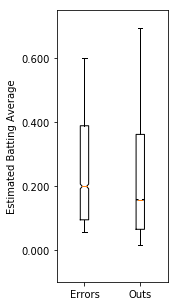

In [47]:
# Test for significant difference between median estimated batting average 
# with a Mann-Whitney U-test

print('Median Estimated BA on Outs:', np.median(out_eba), 
      'Median Estimated BA on Errors:', np.median(error_eba))
mwu, pwu = stats.mannwhitneyu(error_eba, out_eba)
print(pwu)

plt.close()
plt.figure(2, (2, 5))
plt.boxplot([error_eba, out_eba], whis=[5, 95], notch=True, positions = [1, 2], sym='')
plt.ylim((-.1, 0.750))
yt = [0, .2, .4, .6]
plt.yticks(yt)
ytl = ['0.000', '0.200', '0.400', '0.600', '0.800', '1.000']
plt.gca().set_yticklabels(ytl)
plt.gca().set_xticklabels(['Errors', 'Outs'])
plt.ylabel('Estimated Batting Average')
plt.show()

# The outs have significantly higher estimated batting average!
# Effect size small but significant.
# This warrants a little further study

# Questions: 
# (1) There are different sub-classes of outs (fly outs, ground outs, pop-ups)
# Can I cluster batted balls into these profiles,
# Use these clusters to ask which cluster every error belongs in
# And see whether there are systematic differences in these groups.
# For example: are ground ball errors hit harder than ground ball outs?
# Or is the above effect due to a shift in the distribution BETWEEN clusters 
# (e.g. more ground balls, fewer pop-ups)?

# (2) Are there players who systematically hit into more errors than you would expect by chance
# And whose stats are being systematically punished because of it 
# (even though their getting on base provides the team value)? 

In [50]:
np.mean(error_eba) - np.mean(out_eba)

0.01937013590321382

In [48]:
import sys
print(sys.version)

3.5.6 |Anaconda, Inc.| (default, Aug 26 2018, 16:30:03) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
